In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/isic-2024-challenge/sample_submission.csv
/kaggle/input/isic-2024-challenge/train-metadata.csv
/kaggle/input/isic-2024-challenge/test-metadata.csv
/kaggle/input/isic-2024-challenge/test-image.hdf5
/kaggle/input/isic-2024-challenge/train-image.hdf5


KeyboardInterrupt: 

In [4]:
import cv2

In [67]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

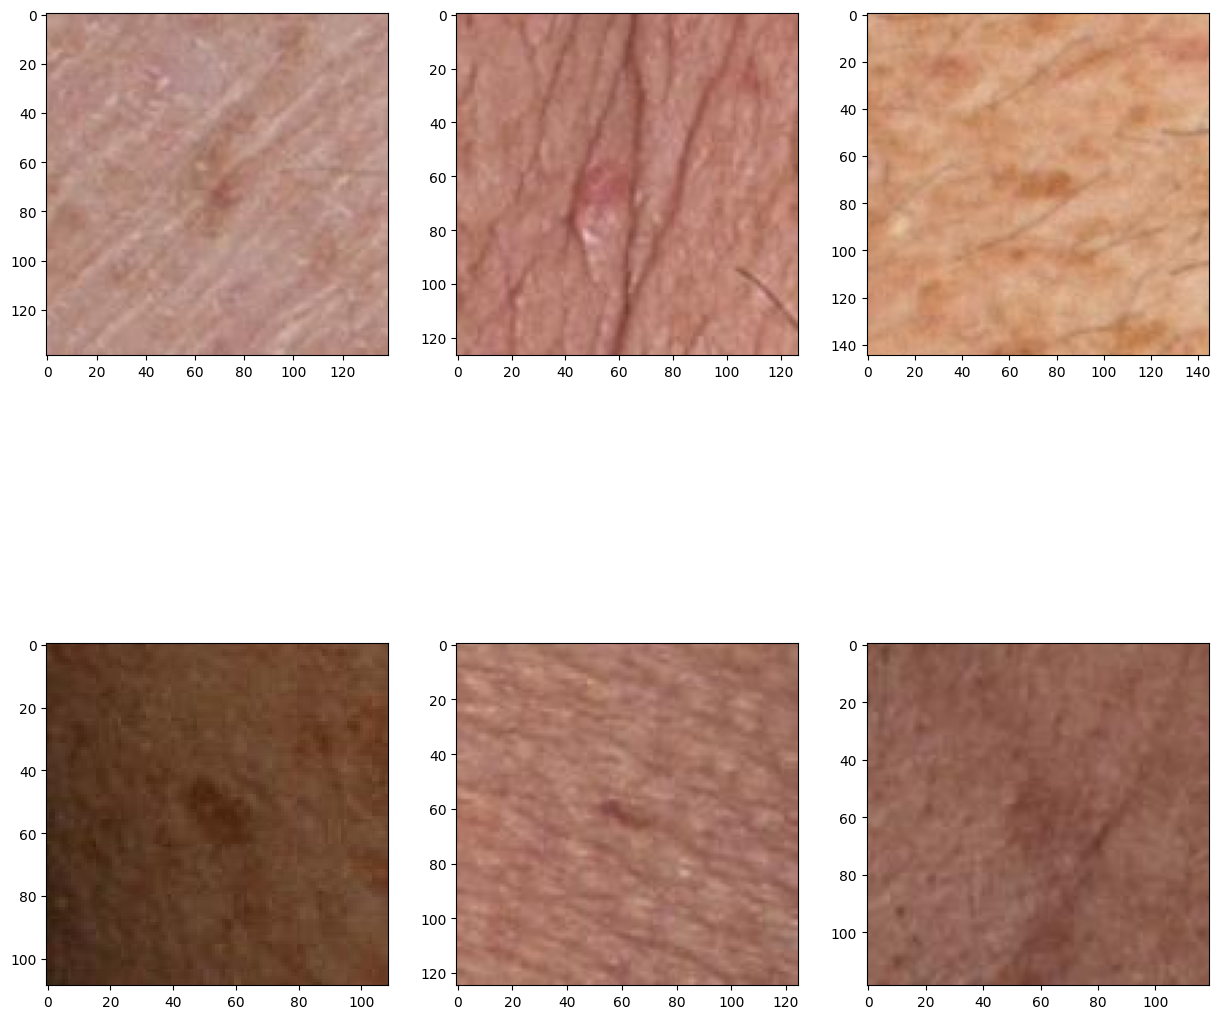

In [72]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(2,3)

i = 0

for image in ['ISIC_0015670.jpg','ISIC_0015845.jpg','ISIC_0015864.jpg','ISIC_0015902.jpg','ISIC_0024200.jpg','ISIC_0035502.jpg']:
    img = cv2.imread('/kaggle/input/isic-2024-challenge/train-image/image/' + image )
    axes[i//3][i%3].imshow(img[:,:,::-1],)
    i += 1

fig.set_size_inches(15,15)
plt.show()

array([<Axes: title={'center': 'OG'}>,
       <Axes: title={'center': 'grayScale'}>,
       <Axes: title={'center': 'blackhat'}>,
       <Axes: title={'center': 'threshold'}>,
       <Axes: title={'center': 'Repaint'}>], dtype=object)

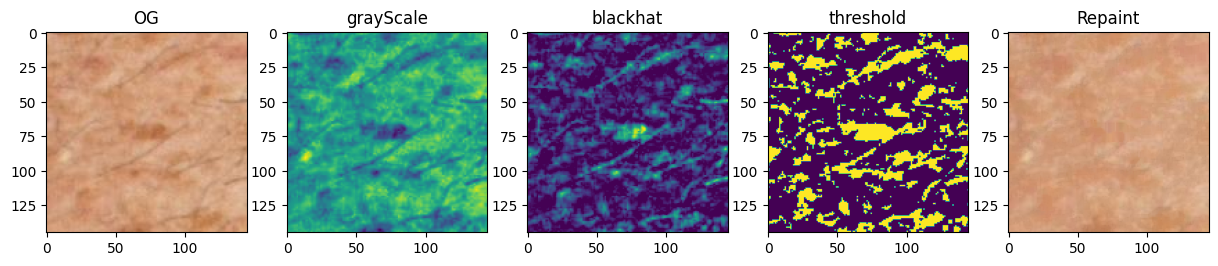

In [101]:
def plot_hair_remove(image):
    fig,axes = plt.subplots(nrows = 1,ncols = 5,figsize = (15,20))
    # OG image
    axes[0].imshow(image)
    axes[0].set_title('OG')
    
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    axes[1].imshow(grayScale)
    axes[1].set_title('grayScale')
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    axes[2].imshow(blackhat)
    axes[2].set_title('blackhat')
    
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    axes[3].imshow(threshold)
    axes[3].set_title('threshold')

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    axes[4].imshow(final_image)
    axes[4].set_title('Repaint')

    return axes

plot_hair_remove(cv2.imread('/kaggle/input/isic-2024-challenge/train-image/image/' + 'ISIC_0015864.jpg')[:,:,::-1])

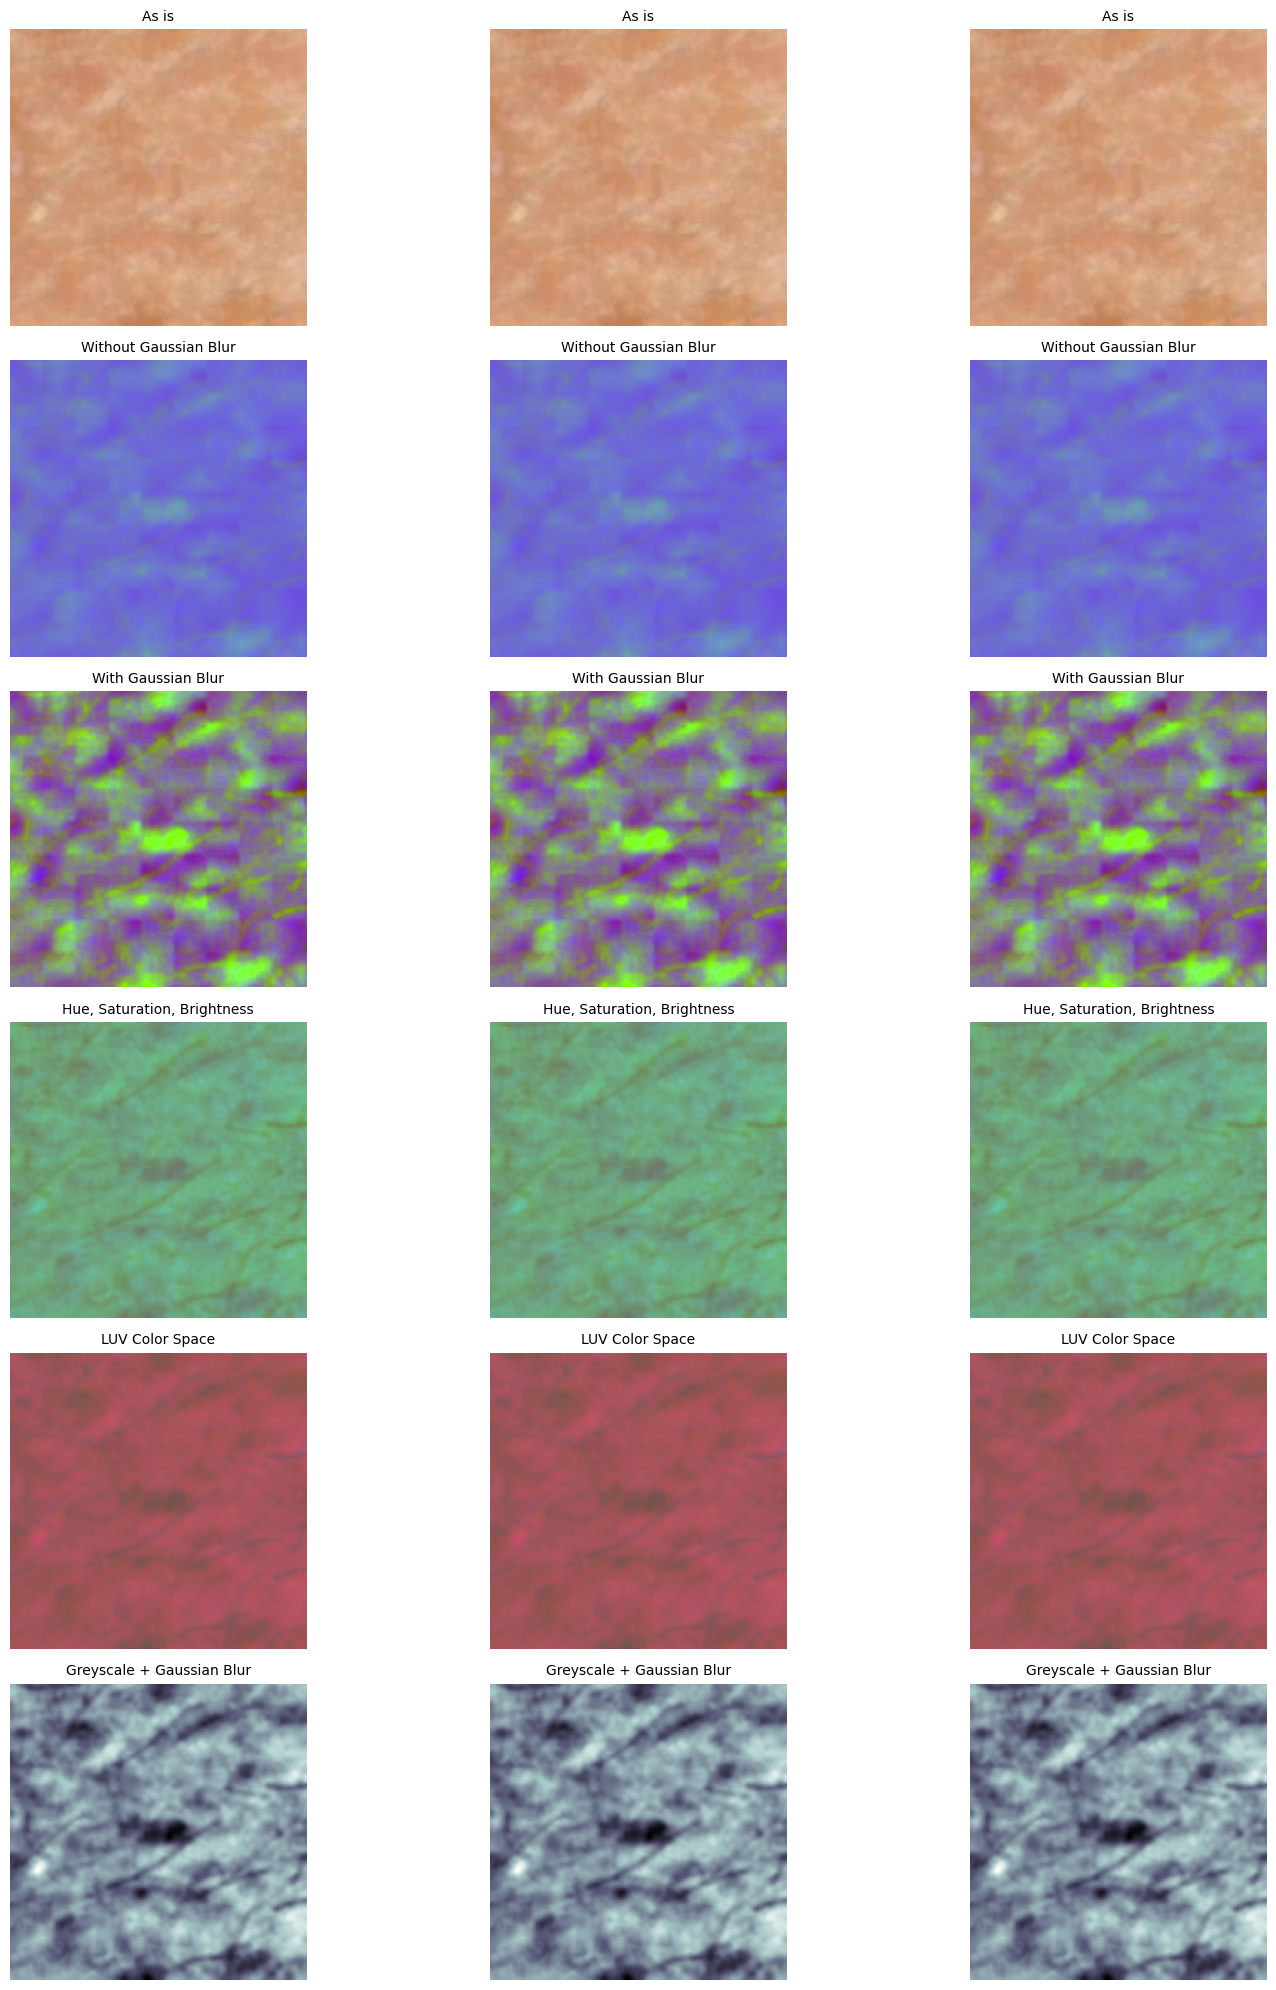

In [88]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

def apply_transformations(image_paths):
    selected_images = np.random.choice(image_paths, 3, replace=False)

    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 20))
    methods = ["As is",
                "Without Gaussian Blur", 
               "With Gaussian Blur", 
               "Hue, Saturation, Brightness",
               "LUV Color Space", 
               "Greyscale + Gaussian Blur",
               ]
    
    for index, method in enumerate(methods):
        for i, path in enumerate(selected_images):
            image = cv2.imread(path)[:,:,::-1]

            if method == "Without Gaussian Blur":
                transformed_image = hair_remove(image)
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "With Gaussian Blur":
                transformed_image = hair_remove(image)
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.addWeighted(transformed_image, 4, cv2.GaussianBlur(transformed_image, (0, 0), 256/10), -4, 128)

            elif method == "Hue, Saturation, Brightness":
                transformed_image = hair_remove(image)
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "LUV Color Space":
                transformed_image = hair_remove(image)
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
                transformed_image = cv2.resize(transformed_image, (200, 200))

            elif method == "Greyscale + Gaussian Blur":
                transformed_image = hair_remove(image)
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.GaussianBlur(transformed_image, (5, 5), 0)
            else:
                transformed_image = cv2.resize(hair_remove(image),(200, 200))

            axes[index, i].imshow(transformed_image, cmap=plt.cm.bone if len(transformed_image.shape) == 2 else None)
            axes[index, i].axis('off')
            axes[index, i].set_title(method, fontsize=10)

    plt.tight_layout()
    plt.show()

images = ['ISIC_0015864.jpg','ISIC_0015864.jpg','ISIC_0015864.jpg']
# images = ['ISIC_0015670.jpg','ISIC_0015845.jpg','ISIC_0015864.jpg','ISIC_0015902.jpg','ISIC_0024200.jpg','ISIC_0035502.jpg']
path_list = ['/kaggle/input/isic-2024-challenge/train-image/image/' + i for i in images]

apply_transformations(path_list)